# NYC MTA Turnstile Dataset - EDA and Processing

The NYC MTA turnstile datasets have a notorious reputation for being very dirty and difficult to explore. Let's put this to the test!

Note: The datasets can be found at http://web.mta.info/developers/turnstile.html

### Package Imports

In [2]:
import os
import statistics
import datetime
cwd = os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
plt.style.use('seaborn')

### Data Download:

In [3]:
#Let's pull in a few weeks' data

url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
weeks = ['161231', '170107', '170114', '170121']
dfs = []
for i in weeks:
    final_url = url.format(i)
    dfs.append(pd.read_csv(final_url))
df = pd.concat(dfs)

#Let's see how big this dataset is
df.shape

(775905, 11)

In [4]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [8]:
#Looks like the 'EXITS' column has extra trailing spaces. Let's just clean up all column names.
df.columns = df.columns.str.strip()
df.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,03:00:00,REGULAR,5980509,2025806,2016-12-24 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,07:00:00,REGULAR,5980531,2025818,2016-12-24 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,11:00:00,REGULAR,5980613,2025912,2016-12-24 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,15:00:00,REGULAR,5980899,2025965,2016-12-24 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,19:00:00,REGULAR,5981382,2026001,2016-12-24 19:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/24/2016,23:00:00,REGULAR,5981539,2026021,2016-12-24 23:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/25/2016,03:00:00,REGULAR,5981604,2026032,2016-12-25 03:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/25/2016,07:00:00,REGULAR,5981610,2026035,2016-12-25 07:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/25/2016,11:00:00,REGULAR,5981657,2026064,2016-12-25 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/25/2016,15:00:00,REGULAR,5981762,2026094,2016-12-25 15:00:00


In [6]:
#Checking the datatypes of columns
df.dtypes

C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object

In [7]:
#That's not good news! Let's turn this into a time-series dataset first.
df['DATE_TIME'] = pd.to_datetime(df['DATE']+' '+df['TIME'])
df['DATE'] = pd.to_datetime(df['DATE'])

In [8]:
df.dtypes

C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DATE                                                                    datetime64[ns]
TIME                                                                            object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
DATE_TIME                                  

### Hmm, it looks like something fishy is going on with the entry and exit numbers at each turnstile. Let's take a closer look:

In [19]:
df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME']).head(20)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-24,03:00:00,REGULAR,5980509,2025806,2016-12-24 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-24,07:00:00,REGULAR,5980531,2025818,2016-12-24 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-24,11:00:00,REGULAR,5980613,2025912,2016-12-24 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-24,15:00:00,REGULAR,5980899,2025965,2016-12-24 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-24,19:00:00,REGULAR,5981382,2026001,2016-12-24 19:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-24,23:00:00,REGULAR,5981539,2026021,2016-12-24 23:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-25,03:00:00,REGULAR,5981604,2026032,2016-12-25 03:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-25,07:00:00,REGULAR,5981610,2026035,2016-12-25 07:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-25,11:00:00,REGULAR,5981657,2026064,2016-12-25 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2016-12-25,15:00:00,REGULAR,5981762,2026094,2016-12-25 15:00:00


It appears that a reading is taken every 4 hours for each turnstile. Also, the total number of entries and exits for a turnstile at a particular timestamp appears to be a rolling total. This tells us that if we need the total entries/exits for a turnstile at a timestamp, we must subtract those values with the total entries/exits of the preceding timestamp.

In [20]:
#Total entries per turnstile per day (i.e. one row per turnstile per day)
df_day_entries = (df.groupby(['STATION', 'DATE', 'C/A', 'UNIT', 'SCP'])
                  .ENTRIES.max()
                  .reset_index()
                  .sort_values(['STATION', 'C/A', 'UNIT', 'SCP', 'DATE'])) 

In [21]:
df_day_entries.head()

,STATION,DATE,C/A,UNIT,SCP,ENTRIES
0,1 AV,2016-12-24,H007,R248,00-00-00,11876914
10,1 AV,2016-12-25,H007,R248,00-00-00,11877901
20,1 AV,2016-12-26,H007,R248,00-00-00,11879506
30,1 AV,2016-12-27,H007,R248,00-00-00,11882137
40,1 AV,2016-12-28,H007,R248,00-00-00,11885878


In [22]:
#Total daily entries per turnstile
df_day_entries[['PREV_DATE', 'PREV_ENTRIES']] = (df_day_entries
                                                 .groupby(['STATION', 'C/A', 'UNIT', 'SCP'])['DATE', 'ENTRIES']
                                                 .transform(lambda x: x.shift(1)))

In [23]:
df_day_entries['DAY_ENTRIES'] = df_day_entries['ENTRIES'] - df_day_entries['PREV_ENTRIES']
df_day_entries = df_day_entries.dropna()

In [24]:
df_day_entries.head()

,STATION,DATE,C/A,UNIT,SCP,ENTRIES,PREV_DATE,PREV_ENTRIES,DAY_ENTRIES
10,1 AV,2016-12-25,H007,R248,00-00-00,11877901,2016-12-24,11876914.0,987.0
20,1 AV,2016-12-26,H007,R248,00-00-00,11879506,2016-12-25,11877901.0,1605.0
30,1 AV,2016-12-27,H007,R248,00-00-00,11882137,2016-12-26,11879506.0,2631.0
40,1 AV,2016-12-28,H007,R248,00-00-00,11885878,2016-12-27,11882137.0,3741.0
50,1 AV,2016-12-29,H007,R248,00-00-00,11889056,2016-12-28,11885878.0,3178.0


### Let's plot the daily time-series of a particular station:

In [25]:
#Let's dive into data for the 1st AV station
df_day_entries_1av = df_day_entries[df_day_entries['STATION'].str.contains('1 AV')]

In [46]:
df_day_entries_1av.shape

(270, 9)

In [32]:
df_day_entries_1av.head()

,STATION,DATE,C/A,UNIT,SCP,ENTRIES,PREV_DATE,PREV_ENTRIES,DAY_ENTRIES
10,1 AV,2016-12-25,H007,R248,00-00-00,11877901,2016-12-24,11876914.0,987.0
20,1 AV,2016-12-26,H007,R248,00-00-00,11879506,2016-12-25,11877901.0,1605.0
30,1 AV,2016-12-27,H007,R248,00-00-00,11882137,2016-12-26,11879506.0,2631.0
40,1 AV,2016-12-28,H007,R248,00-00-00,11885878,2016-12-27,11882137.0,3741.0
50,1 AV,2016-12-29,H007,R248,00-00-00,11889056,2016-12-28,11885878.0,3178.0


In [43]:
#How many turnstiles does the station have?
df_day_entries_1av.groupby(['STATION', 'C/A', 'UNIT', 'SCP']).ngroups

10

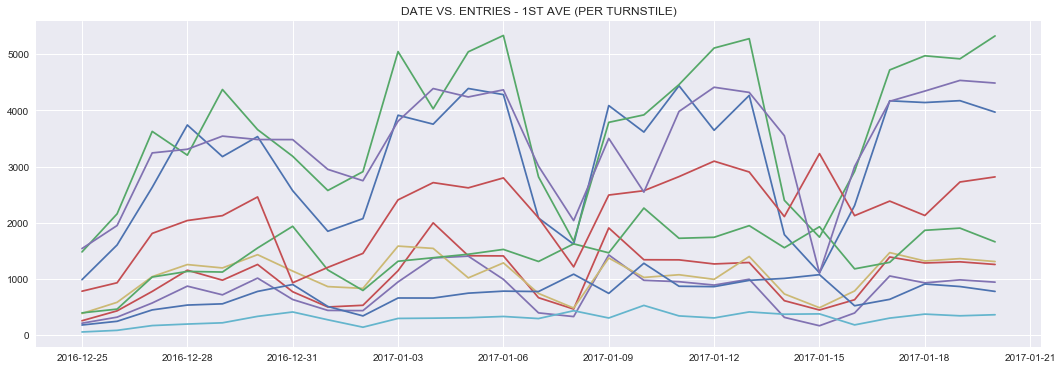

In [64]:
temp_grp = df_day_entries_1av.groupby(['STATION', 'C/A', 'UNIT', 'SCP'])
plt.figure(figsize=(18,6))
for i, g in temp_grp:
    plt.plot(g['DATE'], g['DAY_ENTRIES'])
    plt.title('DATE VS. ENTRIES - 1ST AVE (PER TURNSTILE)');

#### Side Notes: 
- As we can see, the subway traffic starts off low at around Christmas, dips again around new years eve. and then slowly picks up as the holiday season ends. 
- The weekend of January 15th was a long weekend (MLK Jr. day). We can see subway traffic dip around that time as well. 
- We can also see general subway traffic dips on weekends compared to the weekdays.
- It looks like not all turnstiles in the station are being equally used.

### Aggregating the original data up, to the station level:

In [65]:
#Let's combine turnstiles in the same ControlArea/Unit/Station combo
df_day_entries_suc = df_day_entries.groupby(['STATION', 'DATE', 'C/A', 'UNIT']).DAY_ENTRIES.sum().reset_index()

In [66]:
df_day_entries_suc.shape

(19659, 5)

In [68]:
df_day_entries_suc.head()

,STATION,DATE,C/A,UNIT,DAY_ENTRIES
0,1 AV,2016-12-25,H007,R248,3321.0
1,1 AV,2016-12-25,H008,R248,2955.0
2,1 AV,2016-12-26,H007,R248,5100.0
3,1 AV,2016-12-26,H008,R248,3677.0
4,1 AV,2016-12-27,H007,R248,8649.0


In [69]:
#We now combine everything to give us total entries per day per station
df_day_entries_final = df_day_entries.groupby(['STATION', 'DATE']).DAY_ENTRIES.sum().reset_index()

In [70]:
df_day_entries_final.head()

,STATION,DATE,DAY_ENTRIES
0,1 AV,2016-12-25,6276.0
1,1 AV,2016-12-26,8777.0
2,1 AV,2016-12-27,15357.0
3,1 AV,2016-12-28,17444.0
4,1 AV,2016-12-29,18011.0


### Time-series for a station:

In [71]:
#Let's go back to the 1st ave station to see how the entries vary by day at the station level
#(previous plot was at the turnstile level)

df_day_entries_1av_final = df_day_entries_final[df_day_entries_final['STATION'].str.contains('1 AV')]
entries1 = list(df_day_entries_1av_final['DAY_ENTRIES'])
dates1 = list(df_day_entries_1av_final['DATE'])

In [76]:
df_day_entries_1av_final.shape

(27, 3)

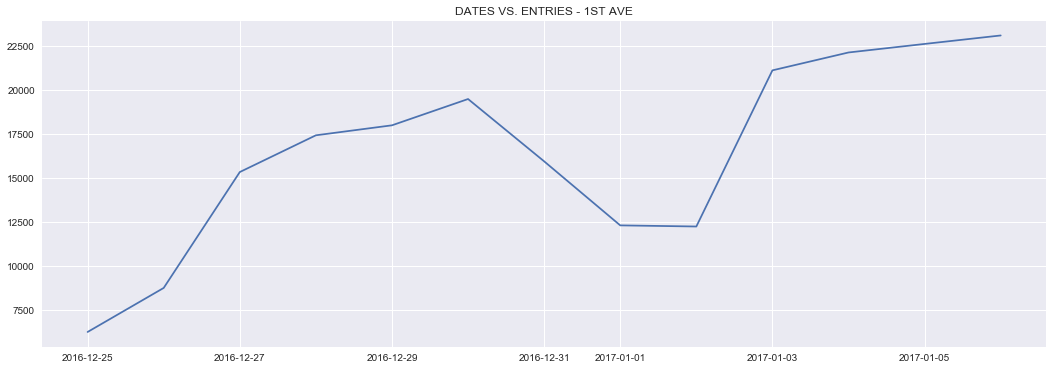

In [123]:
plt.figure(figsize=(18, 6))
plt.plot(dates1, entries1)
plt.title('DATES VS. ENTRIES - 1ST AVE');

### Subway traffic by day of week:

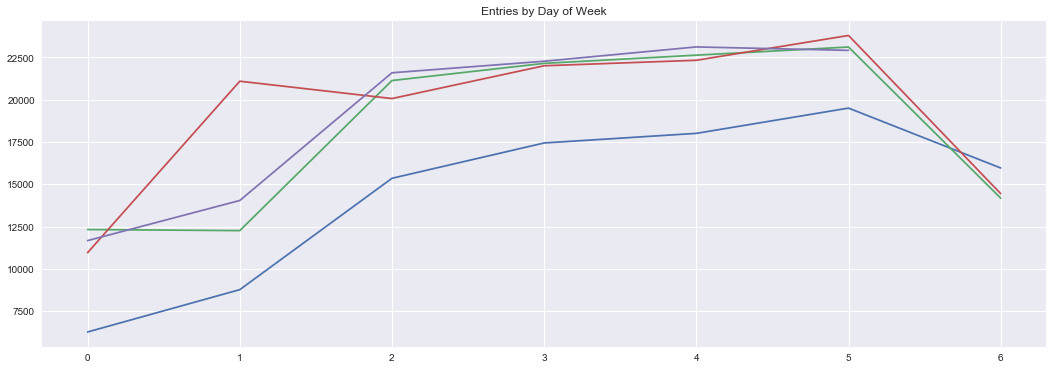

In [79]:
#Here, we're creating a list of lists where each list within the main list contains the entries for each day
#We are also plotting within the loop which will help us superimpose plots as we go through the weeks
#The following is specific to the 1st Ave. station
start = df_day_entries_1av_final['DATE'].min()
end = start + datetime.timedelta(days=6)
end_max = df_day_entries_1av_final['DATE'].max()
week_count_list = []
plt.figure(figsize=(18, 6))
while start < end_max:
    #print('entered')
    temp_df = df_day_entries_1av_final[(df_day_entries_1av_final['DATE']>=start) & (df_day_entries_1av_final['DATE']<=end)]
    temp_entries = list(temp_df['DAY_ENTRIES'])
    #print(temp_entries)
    week_count_list.append(temp_entries)
    start = start + datetime.timedelta(days=7)
    end = start + datetime.timedelta(days=6)
    plt.plot(temp_entries)
    plt.title('Entries by Day of Week')
    #Each line represents a day of week



Well, looks like that's about it to get started with this data. Congratulations! You now know your way around the MTA turnstile datasets.